# 04_Evaluation

## Imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import hdbscan
import umap
import joblib  
import plotly.express as px
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
    silhouette_samples
)

## Load data

In [37]:
hdb = joblib.load('../models/hdbscan_model.joblib')
df = pd.read_csv('../data/processed/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]
y = df['is_attack']

## Evaluation metrics

### External index

In [38]:
hdb_labels = hdb.fit_predict(X)

# Usar hdb.labels_ o hdb_labels (son equivalentes tras fit_predict)
mask = hdb_labels != -1  # o: mask = hdb.labels_ != -1

X_clustered = X[mask]
labels_clustered = hdb_labels[mask]  # o: hdb.labels_[mask]
y_clustered = y[mask]

metrics = {}

# Métricas externas
metrics["Homogeneity"] = homogeneity_score(y_clustered, labels_clustered)
metrics["Completeness"] = completeness_score(y_clustered, labels_clustered)
metrics["V-measure"] = v_measure_score(y_clustered, labels_clustered)

### Internal Index : Silhouette Scores

In [39]:
metrics["Silhouette"] = silhouette_score(
    X_clustered,
    labels_clustered,
    metric='euclidean'
)
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['score'])


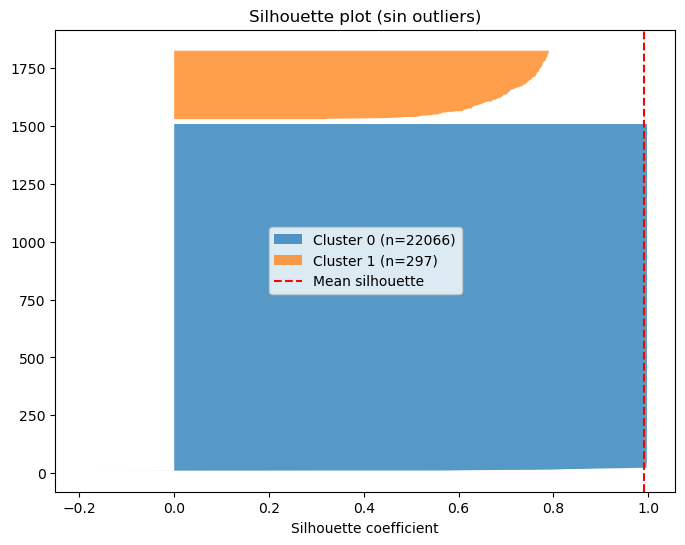

In [40]:
silhouette_vals = silhouette_samples(
    X_clustered,
    labels_clustered)


fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10
max_height = 1500  # altura visual máxima por cluster

for cluster in np.unique(labels_clustered):
    vals = silhouette_vals[labels_clustered == cluster]
    vals.sort()

    # Subsample si el cluster es enorme
    if len(vals) > max_height:
        idx = np.linspace(0, len(vals)-1, max_height).astype(int)
        vals_plot = vals[idx]
    else:
        vals_plot = vals

    size = len(vals_plot)
    y_upper = y_lower + size

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        vals_plot,
        alpha=0.75,
        label=f"Cluster {cluster} (n={len(vals)})"
    )

    y_lower = y_upper + 20

ax.axvline(x=metrics["Silhouette"], color="red", linestyle="--", label="Mean silhouette")
ax.set_xlabel("Silhouette coefficient")
ax.set_title("Silhouette plot (sin outliers)")
ax.legend()
plt.show()


### Every metric

In [41]:
import plotly.express as px

fig = px.bar(
    metrics_df.reset_index(),
    x='index',
    y='score',
    title='Clustering Metrics (HDBSCAN)',
    text='score'
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(yaxis_range=[0, 1])
fig.show()
